# Food Desert Definition Analysis

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from dataprocessing import get_blockgroup_data, get_blockgroupshape

KeyboardInterrupt: 

In [195]:
df = get_blockgroup_data()
gdf = get_blockgroupshape()

In [196]:
df['Low Income'] = np.where(df['Percent Poverty Level'] >= 0.2, 1, 0)

## Initial Exploration

EDA graphs

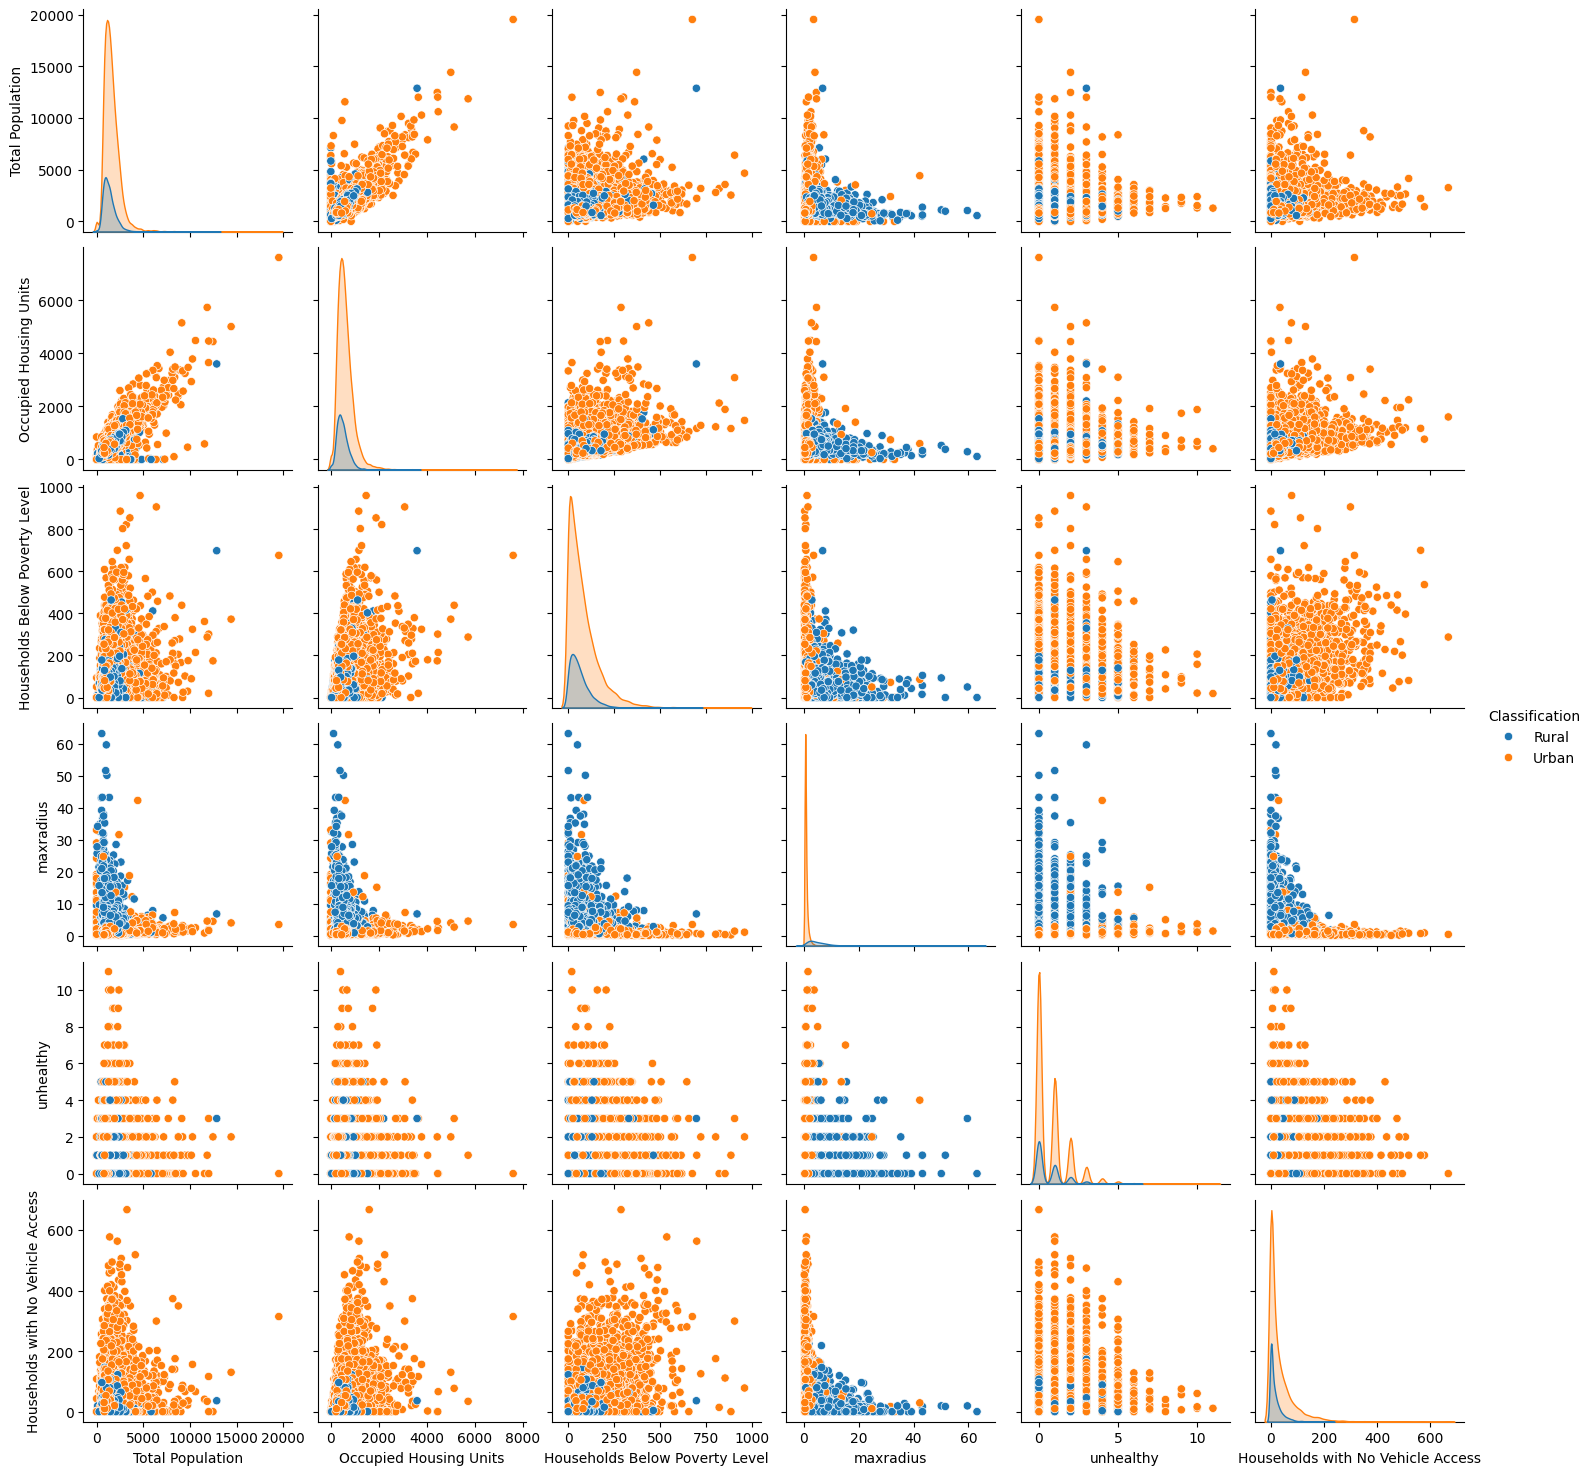

In [197]:
df_eda = df[['Total Population', 'Occupied Housing Units', 'Households Below Poverty Level',
             'maxradius', 'unhealthy', 'Classification', 'Households with No Vehicle Access']]

sns.pairplot(df_eda, hue="Classification")

array([[<Axes: title={'center': 'Total Population'}>,
        <Axes: title={'center': 'Occupied Housing Units'}>],
       [<Axes: title={'center': 'Households Below Poverty Level'}>,
        <Axes: title={'center': 'maxradius'}>],
       [<Axes: title={'center': 'unhealthy'}>,
        <Axes: title={'center': 'Households with No Vehicle Access'}>]],
      dtype=object)

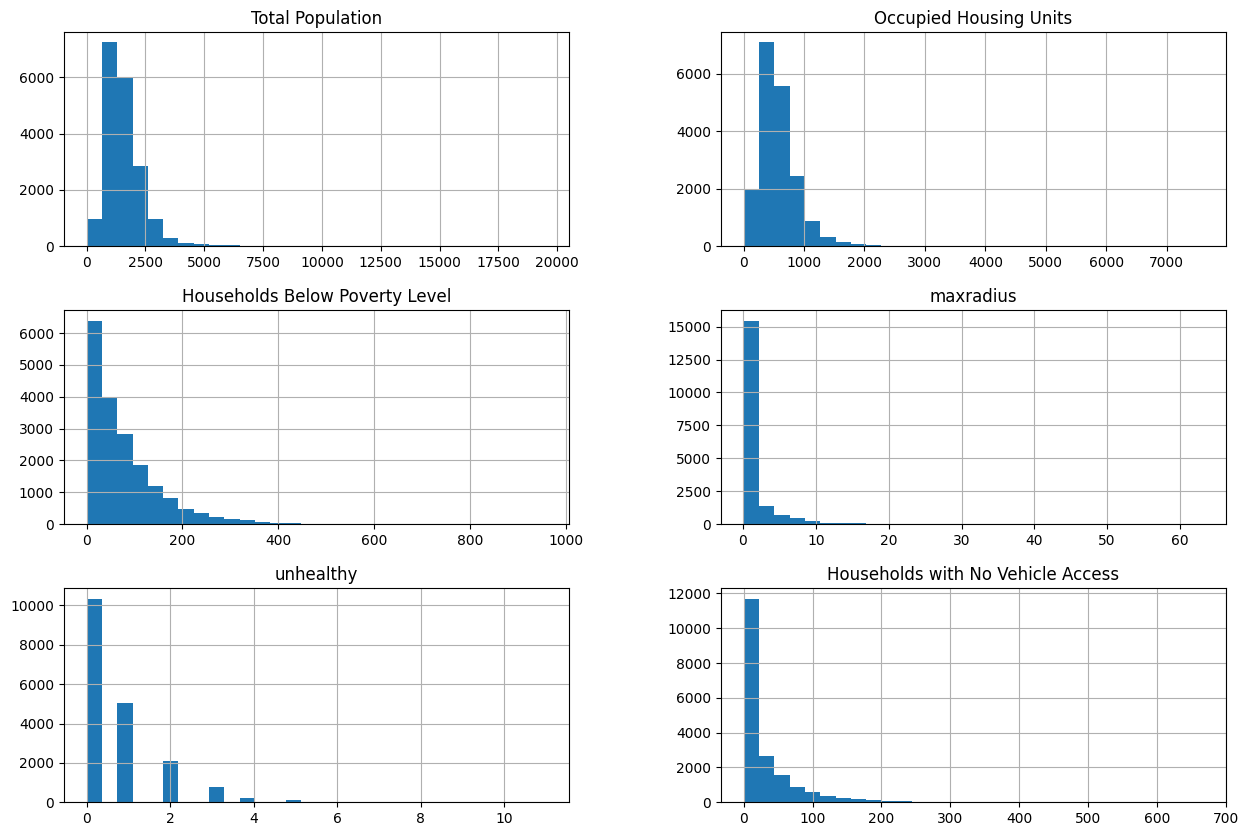

In [198]:
df_eda.hist(bins=30, figsize=(15, 10))

<Axes: xlabel='Classification', ylabel='count'>

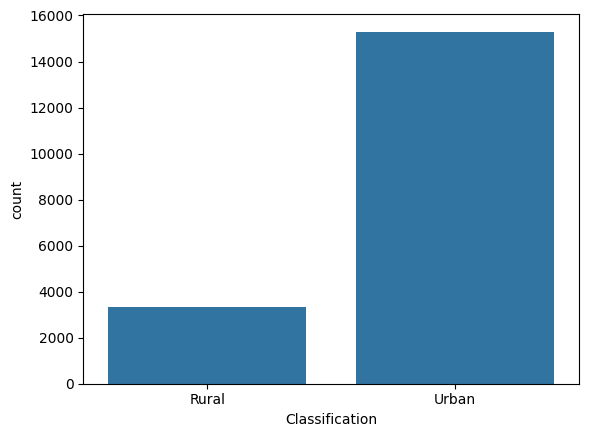

In [199]:
sns.countplot(x=df_eda['Classification'])

<Axes: xlabel='Classification', ylabel='Total Population'>

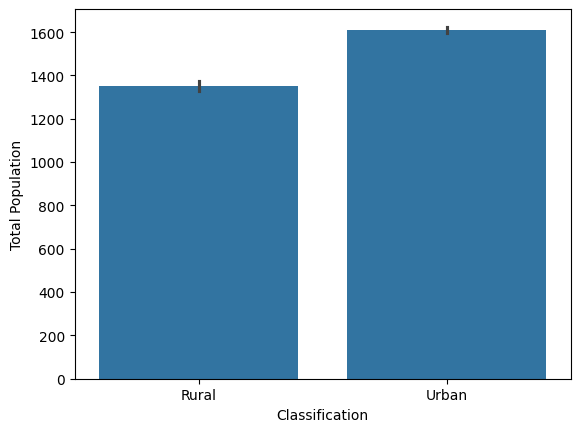

In [200]:
sns.barplot(x='Classification', y='Total Population', data=df_eda)

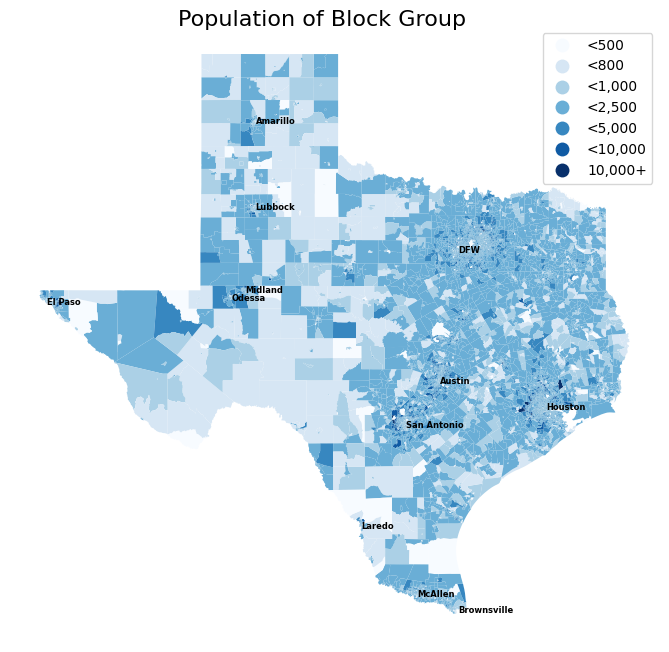

In [201]:
bins = [0, 500, 800, 1000, 2500, 5000, 10000,  np.inf]
labels = ['<500', '<800', '<1,000', '<2,500', '<5,000', '<10,000', '10,000+']
df['Population Bins'] = pd.cut(df['Total Population'], bins=bins, labels=labels)

df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10,8))
df_geo.plot(column='Population Bins', cmap='Blues', legend=True, ax=ax)
ax.set_axis_off()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('Population of Block Group', fontsize=16, y=0.9)

plt.savefig(fname='images/Population.png', dpi = 150)
plt.savefig(fname='images/Populationtransparent.png', dpi = 150, transparent=True)

plt.show()

## USDA Definition Analysis

In [202]:
# low_access flag:
df['USDA Low Access'] = (
    ((df['Classification'] == 'Urban') & (df['Distance_mi'] > 1)) |
    ((df['Classification'] == 'Rural') & (df['Distance_mi'] > 10))).astype(int)
# USDA definition flag
df['USDA Food Desert'] = ((df['Low Income'] == 1) & (df['USDA Low Access'] == 1)).astype(int)

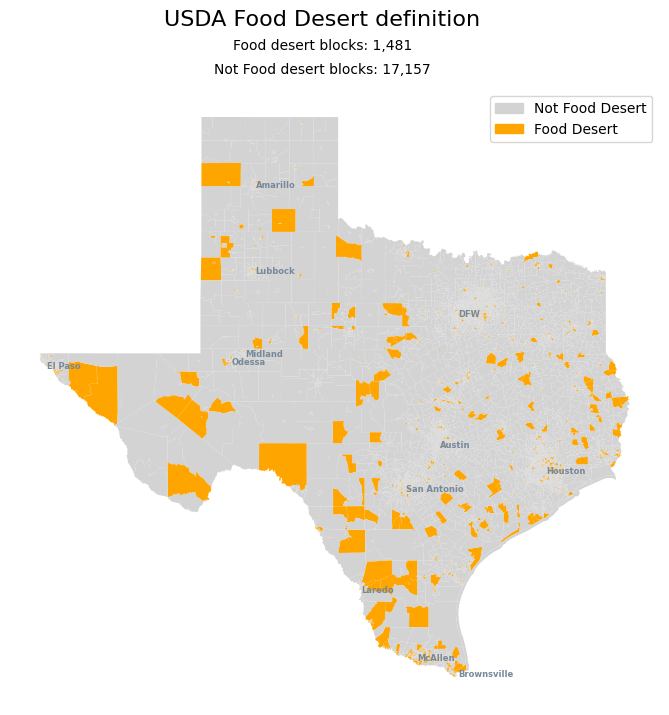

In [203]:
FD_cnt = (df['USDA Food Desert'] == 1).sum()
NFD_cnt =  (df['USDA Food Desert'] == 0).sum()

# converting  USDA_def to a GeoDataFrame 
USDA_def = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'orange'])  # green for 0, lightcoral (red) for 1

USDA_def.plot(column='USDA Food Desert', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# create custom legends using patches 
not_fd_patch = mpatches.Patch(color='lightgray', label='Not Food Desert')
fd_patch = mpatches.Patch(color='orange', label='Food Desert')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='lightslategray',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('USDA Food Desert definition', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Food desert blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food desert blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/USDA.png', dpi = 150)
plt.savefig(fname='images/USDAtransparent.png', dpi = 150, transparent=True)

plt.show()

## CDC Definition Analysis

In [204]:
df['Food Desert CDC'] = np.where(df['Distance_mi'] > 0.5 + df['maxradius'], 1, 0)

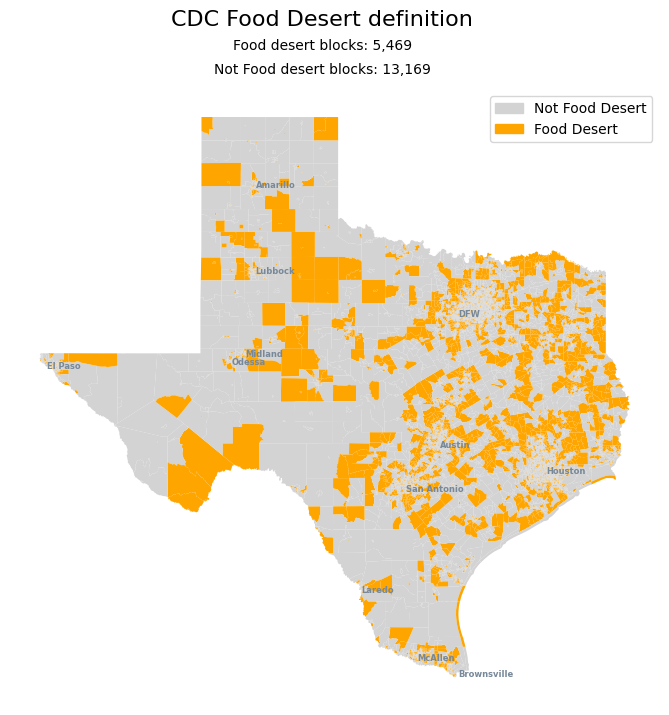

In [205]:
## CDC Definition
df_geo = gpd.GeoDataFrame(df, geometry='geometry')
fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'orange'])

df_geo.plot(column='Food Desert CDC', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='Not Food Desert')
fd_patch = mpatches.Patch(color='orange', label='Food Desert')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['Food Desert CDC'] == 1).sum()
NFD_cnt =  (df['Food Desert CDC'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='lightslategray',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('CDC Food Desert definition', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Food desert blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food desert blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/CDC.png', dpi = 150)
plt.savefig(fname='images/CDCtransparent.png', dpi = 150, transparent=True)

plt.show()

## USDA with Vehicle Analysis

In [206]:
df['Low Access - Vehicle'] = np.where(((df['Percent No Vehicle Access'] > 0.1) & (df['Distance_mi'] > 0.05)) | (df['Distance_mi'] > 20), 1, 0)
df['Food Desert USDA Vehicle'] = np.where((df['Low Income']==1) & (df['Low Access - Vehicle']==1), 1, 0)

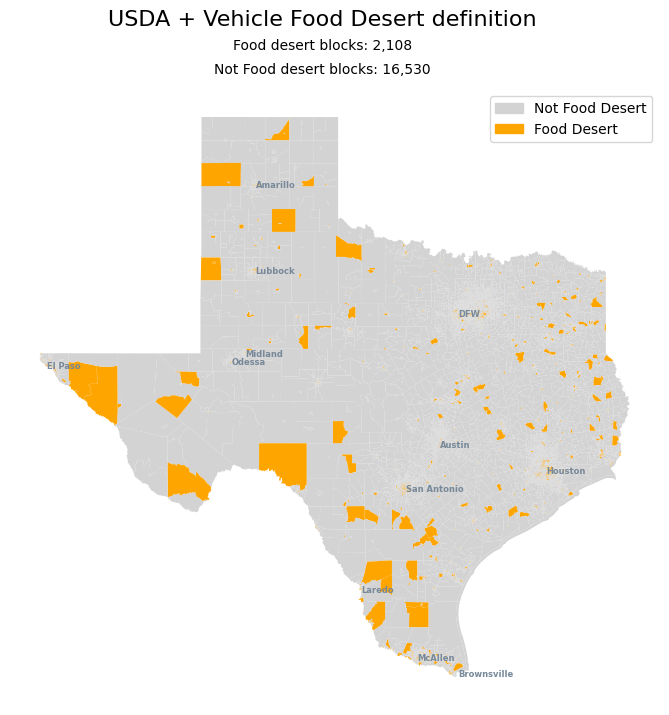

In [207]:
## USDA with Vehicle Access
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'orange'])

df_geo.plot(column='Food Desert USDA Vehicle', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='Not Food Desert')
fd_patch = mpatches.Patch(color='orange', label='Food Desert')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['Food Desert USDA Vehicle'] == 1).sum()
NFD_cnt =  (df['Food Desert USDA Vehicle'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='lightslategray',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('USDA + Vehicle Food Desert definition', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Food desert blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food desert blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/USDAVehicle.png', dpi = 150)
plt.savefig(fname='images/USDAVehicletransparent.png', dpi = 150, transparent=True)

plt.show()

## Food Swamp Analysis

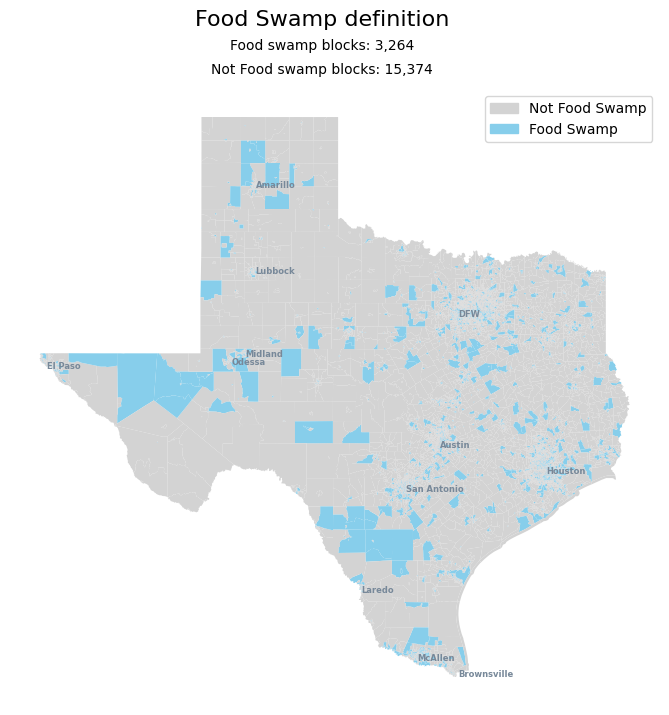

In [208]:
## Food Swamp
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', '#87ceeb'])

df_geo.plot(column='food_swamp_flag', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fs_patch = mpatches.Patch(color='lightgray', label='Not Food Swamp')
fs_patch = mpatches.Patch(color='#87ceeb', label='Food Swamp')

plt.legend(handles=[not_fs_patch, fs_patch], loc='upper right')

FS_cnt = (df['food_swamp_flag'] == 1).sum()
NFS_cnt =  (df['food_swamp_flag'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='lightslategray',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('Food Swamp definition', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Food swamp blocks: {FS_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food swamp blocks: {NFS_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodSwamp.png', dpi = 150)
plt.savefig(fname='images/FoodSwamptransparent.png', dpi = 150, transparent=True)

plt.show()

## Overlap Analysis

In [209]:
df['overlap_usda_usdavehicle'] = np.where((df['USDA Food Desert'] == 1) & (df['Food Desert USDA Vehicle'] == 1), 1, 0)
df['overlap_usda_cdc'] = np.where((df['USDA Food Desert'] == 1) & (df['Food Desert CDC'] == 1), 1, 0)
df['overlap_cdc_usdavehicle'] = np.where((df['Food Desert CDC'] == 1) & (df['Food Desert USDA Vehicle'] == 1), 1, 0)
df['food_desert_all'] = np.where((df['USDA Food Desert'] == 1) & (df['Food Desert CDC'] == 1) & (df['Food Desert USDA Vehicle'] == 1), 1, 0)
df['food_desert_>1'] = np.where(df['USDA Food Desert'] + df['Food Desert CDC'] + df['Food Desert USDA Vehicle'] > 1, 1, 0)

conditions = [
    (df['food_swamp_flag'] == 1) & (df['food_desert_>1'] == 1),
    (df['food_swamp_flag'] == 1) & (df['USDA Food Desert'] == 1),
    (df['food_swamp_flag'] == 1) & (df['Food Desert CDC'] == 1),
    (df['food_swamp_flag'] == 1) & (df['Food Desert USDA Vehicle'] == 1)
]
values = [1, 2, 3, 4]

df['overlap_swamp_desert'] = np.select(conditions, values, default=0)

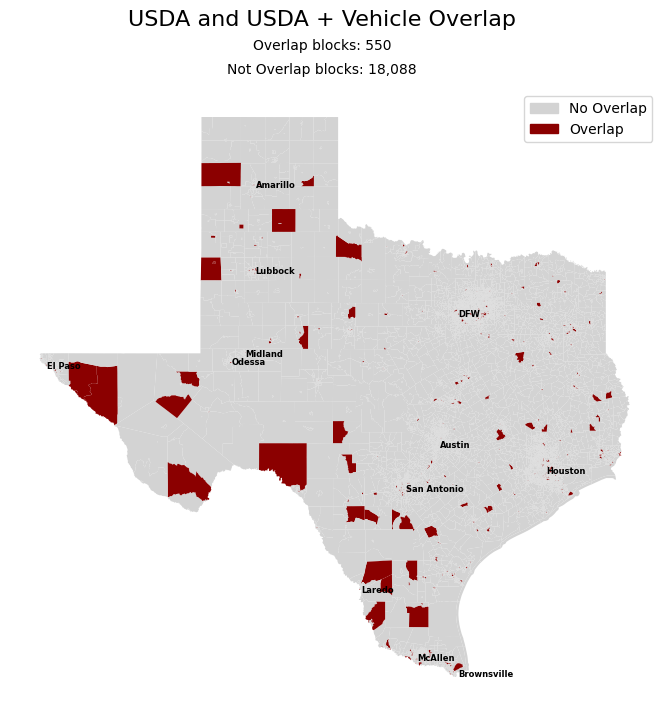

In [210]:
## USDA and USDA_Vehicle Overlap
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'darkred'])

df_geo.plot(column='overlap_usda_usdavehicle', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='No Overlap')
fd_patch = mpatches.Patch(color='darkred', label='Overlap')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['overlap_usda_usdavehicle'] == 1).sum()
NFD_cnt =  (df['overlap_usda_usdavehicle'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('USDA and USDA + Vehicle Overlap', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Overlap blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Overlap blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_USDA_USDAVeh_Overlap.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_USDA_USDAVeh_Overlaptransparent.png', dpi = 150, transparent=True)

plt.show()

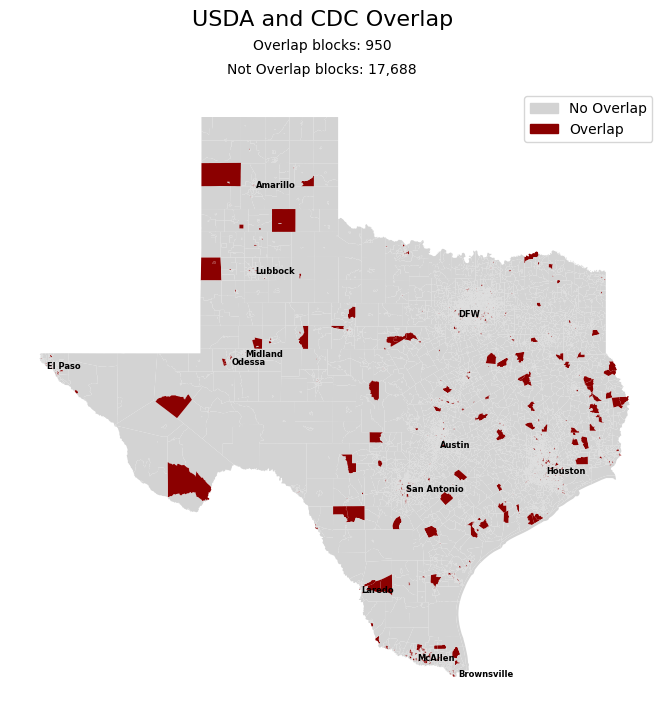

In [211]:
## USDA and CDC Overlap
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'darkred'])

df_geo.plot(column='overlap_usda_cdc', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='No Overlap')
fd_patch = mpatches.Patch(color='darkred', label='Overlap')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['overlap_usda_cdc'] == 1).sum()
NFD_cnt =  (df['overlap_usda_cdc'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('USDA and CDC Overlap', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Overlap blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Overlap blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_USDA_CDC_Overlap.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_USDA_CDC_Overlaptransparent.png', dpi = 150, transparent=True)

plt.show()

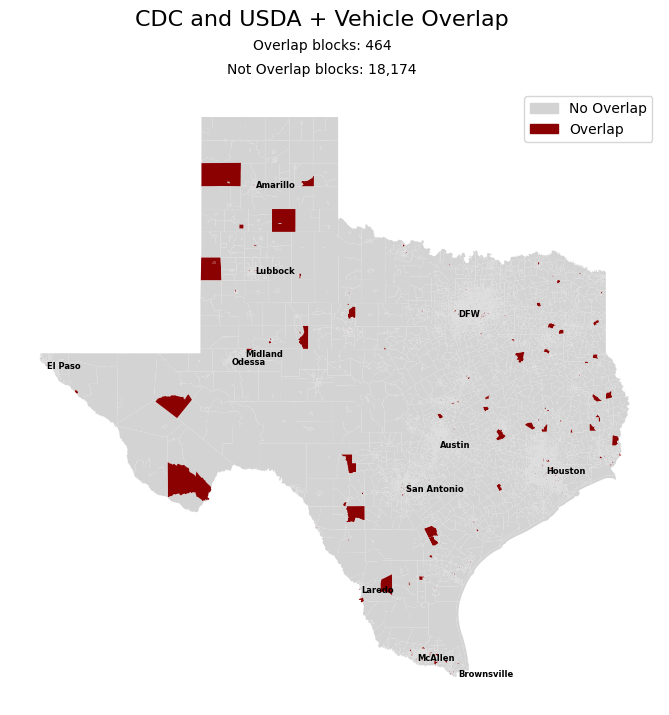

In [212]:
## CDC and USDA_Vehicle Overlap
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'darkred'])

df_geo.plot(column='overlap_cdc_usdavehicle', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='No Overlap')
fd_patch = mpatches.Patch(color='darkred', label='Overlap')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['overlap_cdc_usdavehicle'] == 1).sum()
NFD_cnt =  (df['overlap_cdc_usdavehicle'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('CDC and USDA + Vehicle Overlap', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Overlap blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Overlap blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_CDC_USDAVeh_Overlap.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_CDC_USDAVeh_Overlaptransparent.png', dpi = 150, transparent=True)

plt.show()

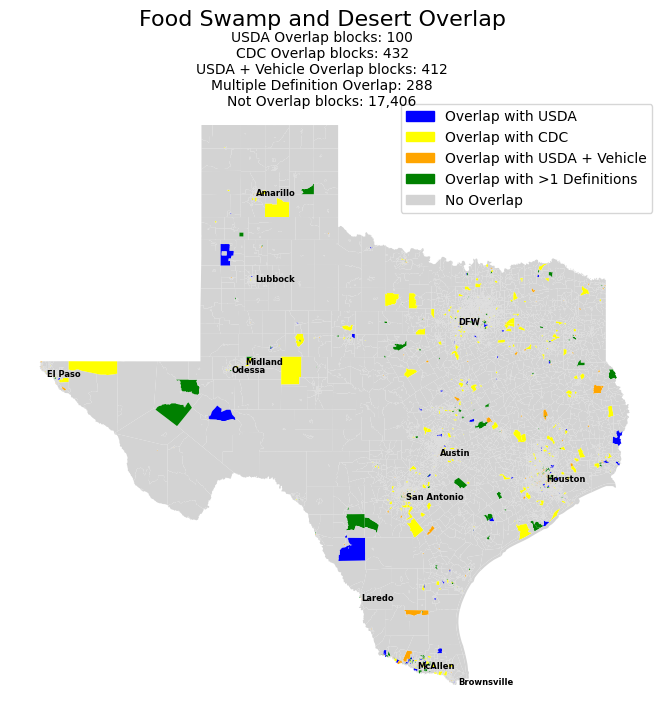

In [213]:
## Food Desert and Food Swamp Overlap
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'green', 'blue', 'yellow', 'orange'])

df_geo.plot(column='overlap_swamp_desert', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_patch = mpatches.Patch(color='lightgray', label='No Overlap')
usda_patch = mpatches.Patch(color='blue', label='Overlap with USDA')
cdc_patch = mpatches.Patch(color='yellow', label='Overlap with CDC')
usdaV_patch = mpatches.Patch(color='orange', label='Overlap with USDA + Vehicle')
all_patch = mpatches.Patch(color='green', label = 'Overlap with >1 Definitions')

plt.legend(handles=[usda_patch, cdc_patch, usdaV_patch, all_patch, not_patch], loc='upper right')

USDA_cnt = (df['overlap_swamp_desert'] == 2).sum()
CDC_cnt = (df['overlap_swamp_desert'] == 3).sum()
USDAV_cnt = (df['overlap_swamp_desert'] == 4).sum()
all_cnt = (df['overlap_swamp_desert'] == 1).sum()
NO_cnt =  (df['overlap_swamp_desert'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('Food Swamp and Desert Overlap', fontsize=16, y=0.99)
fig.text(0.5, 0.95, f'USDA Overlap blocks: {USDA_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.93, f'CDC Overlap blocks: {CDC_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.91, f'USDA + Vehicle Overlap blocks: {USDAV_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.89, f'Multiple Definition Overlap: {all_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.87, f'Not Overlap blocks: {NO_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_Swamp_Overlap.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_Swamp_Overlaptransparent.png', dpi = 150, transparent=True)

plt.show()

## Proposed Definition Analysis

Low income + <br>
- If urban and low vehicle access: 1 mile<br>
- If urban and adequate vehicle access: 10, 15 miles (30 minutes max in vehicle, we assume 20-30 mph avg speed limit in urban areas)<br>
- If rural and low vehicle access: 0.5 mile<br>
- If rural and adequate vehicle access: 20, 30 miles (30 minutes max in vehicle, we assume 40-60 mph avg speed limit in rural areas)<br>


In [214]:
conditions = [
    (df['Low Income'] == 1) & (df['Classification'] == 'Urban') & (df['Percent No Vehicle Access'] <= 0.1) & (df['Distance_mi'] > 15),
    (df['Low Income'] == 1) & (df['Classification'] == 'Rural') & (df['Percent No Vehicle Access'] <= 0.1) & (df['Distance_mi'] > 30),
    (df['Low Income'] == 1) & (df['Classification'] == 'Urban') & (df['Percent No Vehicle Access'] > 0.1) & (df['Distance_mi'] > 1),
    (df['Low Income'] == 1) & (df['Classification'] == 'Urban') & (df['Percent No Vehicle Access'] <= 0.1) & (df['Distance_mi'] > 10),
    (df['Low Income'] == 1) & (df['Classification'] == 'Rural') & (df['Percent No Vehicle Access'] > 0.1) & (df['Distance_mi'] > 0.5),
    (df['Low Income'] == 1) & (df['Classification'] == 'Rural') & (df['Percent No Vehicle Access'] <= 0.1) & (df['Distance_mi'] > 20)
]
values = [2, 2, 1, 1, 1, 1]

df['Proposed Food Desert Definition'] = np.select(conditions, values, default=0)

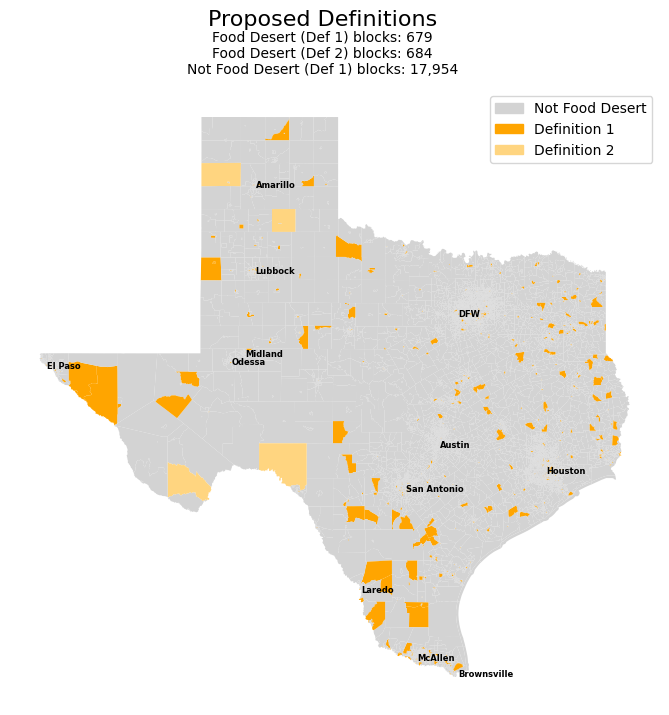

In [215]:
## Proposed Definition
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'orange', '#ffd580'])

df_geo.plot(column='Proposed Food Desert Definition', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='Not Food Desert')
fd1_patch = mpatches.Patch(color='orange', label='Definition 1')
fd2_patch = mpatches.Patch(color='#ffd580', label='Definition 2')

plt.legend(handles=[not_fd_patch, fd1_patch, fd2_patch], loc='upper right')

FD1_cnt = (df['Proposed Food Desert Definition'] == 1).sum()
FD2_cnt = FD1_cnt + (df['Proposed Food Desert Definition'] == 2).sum()
NFD_cnt =  (df['Proposed Food Desert Definition'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('Proposed Definitions', fontsize=16, y=0.98)
fig.text(0.5, 0.94, f'Food Desert (Def 1) blocks: {FD1_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.92, f'Food Desert (Def 2) blocks: {FD2_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food Desert (Def 1) blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_proposed.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_proposedtransparent.png', dpi = 150, transparent=True)

plt.show()

## Final Analysis

Bar chart showing percent of test region designated as a food desert for each tested method<br>
Consensus map highlighting areas consistently identified in all methods

In [216]:
df['overlap_new_usda'] = np.where((df['USDA Food Desert'] == 1) & (df['Proposed Food Desert Definition'] == 1), 1, 0)
df['overlap_new_cdc'] = np.where((df['Food Desert CDC'] == 1) & (df['Proposed Food Desert Definition'] == 1), 1, 0)
df['overlap_new_usdavehicle'] = np.where((df['Food Desert USDA Vehicle'] == 1) & (df['Proposed Food Desert Definition'] == 1), 1, 0)
df['food_desert_all'] = np.where((df['USDA Food Desert'] == 1) & (df['Food Desert CDC'] == 1) & (df['Food Desert USDA Vehicle'] == 1)\
                                  & (df['Proposed Food Desert Definition'] == 1), 1, 0)
df['overlap_new_swamp'] = np.where((df['food_swamp_flag'] == 1) & (df['Proposed Food Desert Definition'] == 1), 1, 0)

In [217]:
## ADD ALL OVERLAP AND NEW DEFINITION AND NEW DEFINITION OVERLAP
df_overlap_primary = df[['food_swamp_flag', 'Classification', 'USDA Food Desert', 'Food Desert CDC', 'Food Desert USDA Vehicle', 'Proposed Food Desert Definition',
                         'overlap_usda_usdavehicle', 'overlap_usda_cdc', 'overlap_cdc_usdavehicle', 'overlap_swamp_desert', 'overlap_new_usda', 'overlap_new_cdc',
                         'overlap_new_usdavehicle', 'overlap_new_swamp', 'food_desert_all']]
df_overlap_primary = df_overlap_primary.replace(0, np.nan)
df_overlap_households = df_overlap_primary.groupby(['Classification']).agg('count')

df_swamppop = df[['Total Population', 'Occupied Housing Units', 'food_swamp_flag', 'Classification']]
df_swamppop = df_swamppop[df_swamppop['food_swamp_flag'] != 0]
df_swamppop = df_swamppop.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'Swamp Pop', 'Occupied Housing Units': 'Swamp Households'}).drop(columns=['food_swamp_flag'])

df_usdapop = df[['Total Population', 'Occupied Housing Units', 'USDA Food Desert', 'Classification']]
df_usdapop = df_usdapop[df_usdapop['USDA Food Desert'] != 0]
df_usdapop = df_usdapop.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'USDA Pop', 'Occupied Housing Units': 'USDA Households'}).drop(columns=['USDA Food Desert'])

df_cdcpop = df[['Total Population', 'Occupied Housing Units', 'Food Desert CDC', 'Classification']]
df_cdcpop = df_cdcpop[df_cdcpop['Food Desert CDC'] != 0]
df_cdcpop = df_cdcpop.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'CDC Pop', 'Occupied Housing Units': 'CDC Households'}).drop(columns=['Food Desert CDC'])

df_usdaVpop = df[['Total Population', 'Occupied Housing Units', 'Food Desert USDA Vehicle', 'Classification']]
df_usdaVpop = df_usdaVpop[df_usdaVpop['Food Desert USDA Vehicle'] != 0]
df_usdaVpop = df_usdaVpop.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'USDA Vehicle Pop', 'Occupied Housing Units': 'USDA Vehicle Households'}).drop(columns=['Food Desert USDA Vehicle'])

df_newpop = df[['Total Population', 'Occupied Housing Units', 'Proposed Food Desert Definition', 'Classification']]
df_newpop = df_newpop[df_newpop['Proposed Food Desert Definition'] != 0]
df_newpop = df_newpop.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'Proposed Definition Pop', 'Occupied Housing Units': 'Proposed Definition Households'}).drop(columns=['Proposed Food Desert Definition'])

df_ov_usda_usdavehicle = df[['Total Population', 'Occupied Housing Units', 'overlap_usda_usdavehicle', 'Classification']]
df_ov_usda_usdavehicle = df_ov_usda_usdavehicle[df_ov_usda_usdavehicle['overlap_usda_usdavehicle'] != 0]
df_ov_usda_usdavehicle = df_ov_usda_usdavehicle.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'USDA x USDA Vehicle Pop', 'Occupied Housing Units': 'USDA x USDA Vehicle Households'}).drop(columns=['overlap_usda_usdavehicle'])

df_ov_usda_cdc = df[['Total Population', 'Occupied Housing Units', 'overlap_usda_cdc', 'Classification']]
df_ov_usda_cdc = df_ov_usda_cdc[df_ov_usda_cdc['overlap_usda_cdc'] != 0]
df_ov_usda_cdc = df_ov_usda_cdc.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'USDA x CDC Pop', 'Occupied Housing Units': 'USDA x CDC Households'}).drop(columns=['overlap_usda_cdc'])

df_ov_cdc_usdavehicle = df[['Total Population', 'Occupied Housing Units', 'overlap_cdc_usdavehicle', 'Classification']]
df_ov_cdc_usdavehicle = df_ov_cdc_usdavehicle[df_ov_cdc_usdavehicle['overlap_cdc_usdavehicle'] != 0]
df_ov_cdc_usdavehicle = df_ov_cdc_usdavehicle.groupby('Classification').agg('sum')\
    .rename(columns={'Total Population': 'CDC x USDA Vehicle Pop', 'Occupied Housing Units': 'CDC x USDA Vehicle Households'}).drop(columns=['overlap_cdc_usdavehicle'])

df_ov_swamp_desert = df[['Total Population', 'Occupied Housing Units', 'overlap_swamp_desert', 'Classification']]
df_ov_swamp_desert = df_ov_swamp_desert[df_ov_swamp_desert['overlap_swamp_desert'] != 0]
df_ov_swamp_desert = df_ov_swamp_desert.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Swamp x Desert Pop', 'Occupied Housing Units': 'Swamp x Desert Households'}).drop(columns=['overlap_swamp_desert'])

df_ov_new_usda = df[['Total Population', 'Occupied Housing Units', 'overlap_new_usda', 'Classification']]
df_ov_new_usda = df_ov_new_usda[df_ov_new_usda['overlap_new_usda'] != 0]
df_ov_new_usda = df_ov_new_usda.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Proposed x USDA Pop', 'Occupied Housing Units': 'Proposed x USDA Households'}).drop(columns=['overlap_new_usda'])

df_ov_new_cdc = df[['Total Population', 'Occupied Housing Units', 'overlap_new_cdc', 'Classification']]
df_ov_new_cdc = df_ov_new_cdc[df_ov_new_cdc['overlap_new_cdc'] != 0]
df_ov_new_cdc = df_ov_new_cdc.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Proposed x CDC Pop', 'Occupied Housing Units': 'Proposed x CDC Households'}).drop(columns=['overlap_new_cdc'])

df_ov_new_usdavehicle = df[['Total Population', 'Occupied Housing Units', 'overlap_new_usdavehicle', 'Classification']]
df_ov_new_usdavehicle = df_ov_new_usdavehicle[df_ov_new_usdavehicle['overlap_new_usdavehicle'] != 0]
df_ov_new_usdavehicle = df_ov_new_usdavehicle.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Proposed x USDA Vehicle Pop', 'Occupied Housing Units': 'Proposed x USDA Vehicle Households'}).drop(columns=['overlap_new_usdavehicle'])

df_ov_new_swamp = df[['Total Population', 'Occupied Housing Units', 'overlap_new_swamp', 'Classification']]
df_ov_new_swamp = df_ov_new_swamp[df_ov_new_swamp['overlap_new_swamp'] != 0]
df_ov_new_swamp = df_ov_new_swamp.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Proposed x Swamp Pop', 'Occupied Housing Units': 'Proposed x Swamp Households'}).drop(columns=['overlap_new_swamp'])

df_ov_all = df[['Total Population', 'Occupied Housing Units', 'food_desert_all', 'Classification']]
df_ov_all = df_ov_all[df_ov_all['food_desert_all'] != 0]
df_ov_all = df_ov_all.groupby(['Classification']).agg('sum')\
    .reset_index().rename(columns={'Total Population': 'Consensus Food Desert Pop', 'Occupied Housing Units': 'Consensus Food Desert Households'}).drop(columns=['food_desert_all'])

df_pops = pd.merge(df_usdapop, df_swamppop, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_cdcpop, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_usdaVpop, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_newpop, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_usda_usdavehicle, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_usda_cdc, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_cdc_usdavehicle, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_swamp_desert, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_new_usda, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_new_cdc, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_new_usdavehicle, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_new_swamp, how='left', on='Classification')
df_pops = pd.merge(df_pops, df_ov_all, how='left', on='Classification')

In [218]:
# plot number of block groups in each designation
df_counts_r = pd.DataFrame(df_overlap_households.transpose()['Rural']).rename(columns={'Rural': 'Count'})
df_counts_r['Type'] = 'Rural'
df_counts_u = pd.DataFrame(df_overlap_households.transpose()['Urban']).rename(columns={'Urban': 'Count'})
df_counts_u['Type'] = 'Urban'
df_counts = pd.concat([df_counts_r, df_counts_u], axis=0).reset_index()
df_counts['index'] = df_counts['index'].map({'Food Desert CDC': 'CDC Food Desert', 'Food Desert USDA Vehicle': 'USDA + Vehicle Food Desert', 
                                                     'food_swamp_flag': 'Food Swamp', 'overlap_cdc_usdavehicle': 'CDC and USDA + Vehicle Food Desert', 
                                                     'USDA Food Desert': 'USDA Food Desert', 'overlap_swamp_desert': 'Food Swamp and Food Desert', 
                                                     'overlap_usda_cdc': 'USDA and CDC Food Desert', 'overlap_usda_usdavehicle': 'USDA and USDA + Vehicle Food Desert',
                                                     'Proposed Food Desert Definition': 'Proposed Food Desert', 'overlap_new_usda': 'Proposed and USDA Food Desert',
                                                     'overlap_new_cdc': 'Proposed and CDC Food Desert', 'overlap_new_usdavehicle': 'Proposed and USDA + Vehicle',
                                                     'overlap_new_swamp': 'Proposed and Food Swamp', 'food_desert_all': 'All Food Deserts'})
df_counts

alt.Chart(df_counts).mark_bar().encode(
    x=alt.X('index:N').axis(title='Designation'),
    y=alt.Y('Count:Q').axis(title='Count of Block Groups'),
    color='Type'
)

alt.Chart(...)

In [219]:
# plot population in each designation
pops = df_pops[['Classification', 'USDA Pop', 'Swamp Pop', 'CDC Pop', 'USDA Vehicle Pop', 'Proposed Definition Pop', 'USDA x USDA Vehicle Pop', 'USDA x CDC Pop',
                'CDC x USDA Vehicle Pop', 'Swamp x Desert Pop', 'Proposed x USDA Pop', 'Proposed x CDC Pop', 'Proposed x USDA Vehicle Pop', 'Proposed x Swamp Pop',
                'Consensus Food Desert Pop']]
df_pops_r = pd.DataFrame(pops.set_index('Classification').transpose()['Rural']).rename(columns={'Rural': 'Population'})
df_pops_r['Type'] = 'Rural'
df_pops_u = pd.DataFrame(pops.set_index('Classification').transpose()['Urban']).rename(columns={'Urban': 'Population'})
df_pops_u['Type'] = 'Urban'
df_pops_final = pd.concat([df_pops_r, df_pops_u], axis=0).reset_index()
df_pops_final


alt.Chart(df_pops_final).mark_bar().encode(
    x=alt.X('index:N').axis(title='Designation'),
    y=alt.Y('Population:Q').axis(title='Population'),
    color='Type'
)

alt.Chart(...)

In [220]:
# plot number of households in each designation
households = df_pops[['Classification', 'USDA Households', 'Swamp Households', 'CDC Households', 'USDA Vehicle Households', 'Proposed Definition Households',
                      'USDA x USDA Vehicle Households', 'USDA x CDC Households', 'CDC x USDA Vehicle Households', 'Swamp x Desert Households',
                      'Proposed x USDA Households', 'Proposed x CDC Households', 'Proposed x USDA Vehicle Households', 'Proposed x Swamp Households',
                      'Consensus Food Desert Households']]
df_households_r = pd.DataFrame(households.set_index('Classification').transpose()['Rural']).rename(columns={'Rural': 'Households'})
df_households_r['Type'] = 'Rural'
df_households_u = pd.DataFrame(households.set_index('Classification').transpose()['Urban']).rename(columns={'Urban': 'Households'})
df_households_u['Type'] = 'Urban'
df_households_final = pd.concat([df_households_r, df_households_u], axis=0).reset_index()
df_households_final


alt.Chart(df_households_final).mark_bar().encode(
    x=alt.X('index:N').axis(title='Designation'),
    y=alt.Y('Households:Q').axis(title='Households'),
    color='Type'
)

alt.Chart(...)

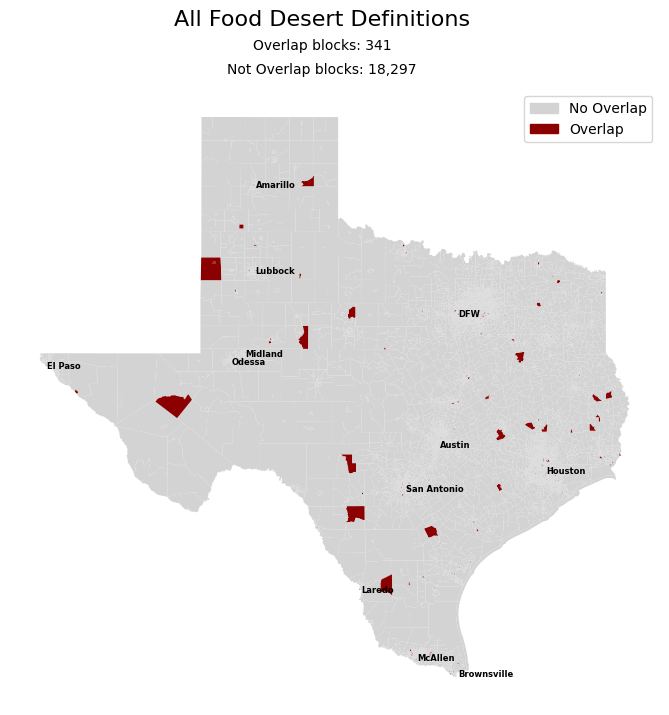

In [221]:
## All Desert Definitions Overlap
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightgray', 'darkred'])

df_geo.plot(column='food_desert_all', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# custom legends
not_fd_patch = mpatches.Patch(color='lightgray', label='No Overlap')
fd_patch = mpatches.Patch(color='darkred', label='Overlap')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

FD_cnt = (df['food_desert_all'] == 1).sum()
NFD_cnt =  (df['food_desert_all'] == 0).sum()

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='black',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('All Food Desert Definitions', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Overlap blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Overlap blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.savefig(fname='images/FoodDesert_all_Overlap.png', dpi = 150)
plt.savefig(fname='images/FoodDesert_all_Overlaptransparent.png', dpi = 150, transparent=True)

plt.show()

In [222]:
pct = df[['USDA Food Desert', 'Food Desert CDC', 'food_swamp_flag', 'Food Desert USDA Vehicle', 'Proposed Food Desert Definition']].rename(columns={'food_swamp_flag': 'Food Swamp'})
pct = pd.DataFrame(pct.replace(0, np.nan).agg('count'))
pct = pct.rename(columns={0: 'Block Group Count'})
totalblockgroups = len(df['Geo Index'].unique())
pct['Percent Desert/Swamp'] = pct['Block Group Count'] / totalblockgroups
pct = pct.reset_index().rename(columns={'index': 'Definition'})

bar = alt.Chart(pct).mark_bar().encode(
        x=alt.X('Definition'),
        y = alt.Y('Percent Desert/Swamp', scale=alt.Scale(domain=[0,1])).axis(format='%')
    ).properties(width=600, height=400)

txt = bar.mark_text(dy=-5).encode(
    text=alt.Text('Percent Desert/Swamp:Q', format='.2%')
)

(bar + txt).properties(title='Percent of Block Groups in Analysis')

alt.LayerChart(...)